# Comparisson with Conv1D-LSTM Networks - Bearing Dataset


## Imports

In [1]:
from collections import OrderedDict

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive


import pandas as pd


# Load data

In [2]:


import os
all_files = [f for f in os.listdir(os.path.join('bearing_fatigue_dataset')) if 'pickle' in f]

load_from_disk = False;
load_first_stage = True
if load_from_disk:
    def load_bearings_dataset(all_files = all_files):
        fnames = all_files
        exp_ids_tot = [];
        yrem_tot = [];
        sensor_values_tot = []

        for kk,fname in enumerate(fnames):
            p1 = pd.read_pickle("bearing_fatigue_dataset/%s"%fname)
            p1['abs_timestamp'] = (p1['h']*60+p1['m'])*60+p1['s']+p1['se-6']/1e6
            
            sensors = p1.groupby("block").apply(lambda x : [x['abs_timestamp'].mean(),np.vstack([x['h_acc'].values, x['v_acc'].values]).T])
            sens_val = np.dstack([v[1] for v in sensors.values])
            sensor_values = np.swapaxes(np.swapaxes(sens_val,0,-1),1,2).astype('float32')
            print(sensor_values.shape)

            yrem = np.vstack([v[0] for v in sensors.values]).astype('float32')
            yrem = np.abs(yrem - np.max(yrem))

            exp_id = np.hstack([kk for v in range(yrem.shape[0])])

            sensor_values_tot.append(sensor_values)
            exp_ids_tot.append(exp_id);
            yrem_tot.append(yrem)

            print(kk)

        yrem_tot = np.vstack(yrem_tot).flatten()
        eid = np.hstack(exp_ids_tot).flatten()
        X__ = np.vstack(sensor_values_tot)
        return yrem_tot, eid, X__
    yrem_s_raw, eid, X = load_bearings_dataset()
    
if load_first_stage:
    L = np.load("first_stage_preproc_bearings.npz")
    yrem_s_raw, X, eid = [L[l] for l in L.files]

## Train/Test splitting
* I need a strong validation set where whole experiments are completely unseen during training.
* I suspect some early interruptions of the experiments (that was from initial investigations). Some experiments ommited.

In [3]:

normalization_factor_time = 25000;
yrem_norm = yrem_s_raw/normalization_factor_time;

yrem_norm[yrem_norm<0.0001] = 0.0001

eid_oh = np.zeros([eid.shape[0],np.max(eid) + 1])
for k in np.unique(eid):
    eid_oh[eid == k,k] = 1.;

#yrem_norm = yrem / np.std(yrem);

#training_set_mask = 
conds_flag_source = [0,0,0,0,   1,1, 1,1,  2,2]
inds_exp_source =  [4,6,8,15,  9,10,0,7,  2,11]

conds_flag_target = [0,0,0,   1, 1, 1,  2]
inds_exp_target  = [1,5,16,  12,13,14,  3]


conds_flag = [*conds_flag_source, *conds_flag_target]
inds_experiments = [*inds_exp_source, *inds_exp_target]
exp_to_cond_dict = {k:v for k,v in zip(inds_experiments, conds_flag)}

loading_cond = [exp_to_cond_dict[k] for i,k in enumerate(np.argmax(eid_oh,1))]
loading_oh = np.zeros([eid_oh.shape[0],3])
for k in np.unique(loading_cond):
    loading_oh[loading_cond == k,k] = 1;


# conds_flag_source = [0,0,0,0,   1,1, 1,1,  2,2]
# inds_exp_source =  [4,6,8,15,  9,10,0,7,  2,11]

# conds_flag_target = [0,0,0,   1,  2]
# inds_exp_target  = [1,5,16,  12,  3]
    


inds_experiments = [*inds_exp_source, *inds_exp_target]

#############################################################
#Remove unused experiments:

ids_filter = [i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_experiments]


X.shape,eid_oh.shape
#inds_exp_source
min_samples_keep = 1000;

exp_and_counts = [(kk,np.sum(eid_oh[:,kk] == 1)) for kk in range(len(inds_exp_source))]
inds_exp_source_new = [];
for e,i in exp_and_counts:
    if i>min_samples_keep:
        inds_exp_source_new.append(e)
#inds_exp_source
print(exp_and_counts)
inds_exp_source = inds_exp_source_new
#inds_exp_source = [2]
print(inds_exp_source)

[(0, 172), (1, 1502), (2, 1637), (3, 515), (4, 871), (5, 1802), (6, 2302), (7, 1202), (8, 1139), (9, 2002)]
[1, 2, 5, 6, 7, 8, 9]


In **GraphNets** I cannot simply randomly sample from different experiments. I need some code to make graph inputs for this dataset.

In [4]:
from fictitious_example.dataset_utils import *
from fictitious_example.minigraphnets import * 

def data_from_experiment(eid, X_ = None, eid_oh_ = None, yrem_norm_ = None):
    ids = (np.argmax(eid_oh_,1) == eid)
    Xexp = X_[ids,:,:];
    yrem_exp_ = yrem_norm_[ids];
    return Xexp, yrem_exp_


def get_indices(ngraphs, ntotal_inds,n_seq_nodes, spacing_ratio = 0.5,
                nnode_range = None,nmax_node_range = 20, fixed_spacing_indices = None):
    """
    A function to sample increasting random indices from index sets.
    
    ngraphs         : how many index sets to sample
    
    ntotal_inds     : the indices of the series. 
    
    n_seq_nodes     : how many nodes should there be per index set sample
    
    spacing_ratio   : this controls how close or far away are the nodes sampled. The larger 
                      it is the further away the nodes are. Smaller than 1.
                      
    nnode_range     : (None) Alternatively from the `spacing_ratio` one can define the actual 
                      number of samples that are skipped.
    
    nmax_node_range : ...
    
    
    """
    
    if nmax_node_range is None:
        nmax_node_range = int(np.floor(ntotal_inds*spacing_ratio));
    
    if nnode_range is None:
        nnode_range = int(np.floor(nmax_node_range/n_seq_nodes));
        
    first_node_range = ntotal_inds - nmax_node_range;
    indices = [];
    
    n = np.random.choice(first_node_range,ngraphs);
        
    indices.append(n)
    for node_idx in range(n_seq_nodes-1):
        if fixed_spacing_indices is None:
            new_idx_shift = np.random.choice(nnode_range, ngraphs);
        else:
            new_idx_shift = fixed_spacing_indices
            
        indices.append(indices[-1] + new_idx_shift)
        
    indices = np.vstack(indices)
    return indices.T

def get_graph_data(experiment,  X_ = None, eid_oh_ = None, yrem_norm_ = None, 
                   n_sampled_graphs = 100, nnodes = 3, min_spacing = 20, max_spacing = 100, fixed_spacing = False, node_time_scaling = 5.):
     
        
    
    fixed_spacing_indices = None
    if fixed_spacing:
        fixed_spacing_indices = min_spacing
    
        
    # For computational efficiency the number of nodes and edges in each graph is the same. 
    # For efficiency in creating the dataset, the nodes and edges are also created in parallel.
    exp_dat = data_from_experiment(experiment, X_ = X_, eid_oh_ = eid_oh_, yrem_norm_ = yrem_norm_)
    ntotal_inds = exp_dat[0].shape[0];
    inds = get_indices(n_sampled_graphs, ntotal_inds, nnodes, fixed_spacing_indices = fixed_spacing_indices)
    X__, y__ = exp_dat;
    node_attr  = [X__[inds_,...] for inds_ in inds.T];
    node_times = [y__[inds_]*node_time_scaling for inds_ in inds.T]; # to be used for making attributes for the edges.
    nodes= [Node(node_attr_) for node_attr_ in node_attr];
    
    ## Connect all edges with all previous edges:
    edges = []
    for i in range(len(nodes)):
        node_to_idx = i
        
        if node_to_idx == 0:
            next #first node does not have an incoming node.
            
        for node_from_idx in range(0, node_to_idx):
            y_from, y_to = [node_times[ni] for ni in [node_from_idx, node_to_idx]]
            edge_attr = y_to - y_from
            #print("node_from/to: %i %i"%(node_from_idx, node_to_idx))
            edges.append(Edge(edge_attr[:,np.newaxis], node_from = nodes[node_from_idx], node_to = nodes[node_to_idx]));
    g__ =Graph(nodes,edges)
    g__.node_times = node_times
    g__.inds = inds
    return g__,node_times[-1] #Returns a graph and a prediction for the time at the graph's destination node.
    
    

def get_graph_data_multiple_experiments(experiments,X_ = None, eid_oh_ = None, yrem_norm_ = None,
                                        nsamples_per_experiment = 100,nnodes = 3, min_spacing = 20, max_spacing = 100, 
                                       fixed_spacing = False):
    all_graph_data = []
    for e in experiments:
        g = get_graph_data(e,  X_ = X_, eid_oh_ = eid_oh_,
                           yrem_norm_ = yrem_norm_,n_sampled_graphs = nsamples_per_experiment,
                          nnodes = nnodes, min_spacing = min_spacing, max_spacing = max_spacing,fixed_spacing = fixed_spacing)
        all_graph_data.append(g)
    return all_graph_data

get_graph_data(0, X_ = X, eid_oh_=eid_oh, yrem_norm_= yrem_norm, nnodes = 4)
    

(<fictitious_example.minigraphnets.Graph at 0x7f1a9029e9e8>,
 array([0.048     , 0.24000001, 0.07      , 0.064     , 0.04      ,
        0.25599998, 0.266     , 0.25800002, 0.186     , 0.12199999,
        0.126     , 0.15599999, 0.326     , 0.07      , 0.104     ,
        0.216     , 0.188     , 0.194     , 0.114     , 0.048     ,
        0.218     , 0.306     , 0.05      , 0.14      , 0.094     ,
        0.262     , 0.184     , 0.266     , 0.09      , 0.27      ,
        0.18200001, 0.238     , 0.332     , 0.284     , 0.174     ,
        0.068     , 0.172     , 0.242     , 0.12      , 0.21400002,
        0.296     , 0.21      , 0.024     , 0.094     , 0.216     ,
        0.12799999, 0.178     , 0.198     , 0.14      , 0.31399998,
        0.168     , 0.24800001, 0.072     , 0.02      , 0.094     ,
        0.266     , 0.17999999, 0.042     , 0.218     , 0.192     ,
        0.27      , 0.306     , 0.21      , 0.15200001, 0.206     ,
        0.054     , 0.168     , 0.164     , 0.20400001,

# LSTM Implementation

In [5]:
# Process all steps in parallel by squeezing the batch dimension.
# reshape to correct (batch,timesteps,embsize) size on output.

def make_node_function(n_edge_state_input = None,n_node_state_input = None):
    
    agg_edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state_agg");
    node_prev_state = Input(shape = (n_node_state_input), name = "node_sender");

    ## Building the edge MLP:
    node_out = keras.layers.concatenate([agg_edge_state_in, node_prev_state]);
    
    #node_out = Dense(100,  name = "node_fcnA")(node_out)
    node_out_nl = Dense(n_node_state_input, activation = "tanh", use_bias = False,name = "node_fcn_nl")(node_out)
    node_out_gate = Dense(n_node_state_input, activation = "sigmoid", use_bias = False,name = "node_fcn_gate")(node_out)
    node_out = node_out_nl  * node_out_gate
    
    node_out_model = Model(inputs = [agg_edge_state_in, node_prev_state] ,outputs = node_out)
    
    return node_out_model

def make_conv_input_head_node_function(edge_input_dummy_size , nfilts = 64, nfilts2 = 128, ksize = 2, output_size = None):
    
    xin_node_ts = tf.keras.Input(shape = (None, 2) , name = "timeseries_input"); 
    xin_edge_dummy = tf.keras.Input(shape = ( edge_input_dummy_size), name = "edge_input_dummy");

    yout = Conv1D(kernel_size = 1 , filters = 100, strides = 1, use_bias = False,name = "conv_fcnA")(xin_node_ts)
    yout = Conv1D(kernel_size=ksize,filters = nfilts, strides=2, use_bias= False,name = "conv_fcnB")(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts,use_bias= False,name = "conv_fcnC")(yout)
    yout = Dropout(rate = 0.2)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts,activation  = "relu",use_bias= True)(yout)
    yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

    yout = Conv1D(kernel_size=ksize, strides=2, filters = nfilts2,use_bias= False)(yout)
    yout = Dropout(rate = 0.2)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,use_bias= False)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,activation  = "relu",use_bias= False)(yout)
    yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

    yout = keras.layers.GlobalAveragePooling1D()(yout)
    yout = Dense(output_size, use_bias = False)(yout)
    mconv = keras.Model(inputs = [xin_edge_dummy,xin_node_ts], outputs = yout)
    return mconv

def make_edge_function_gi(n_edge_state_input = None, n_edge_state_output = None, n_node_state_input = None):
    # for graph independent.
    if n_edge_state_output is None:
        n_edge_state_output = n_edge_state_input
            

    edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state");
    edge_out = edge_state_in
    
    edge_out = Dense(100,  use_bias = True, name = "edge_gi_fcnA")(edge_out)
    edge_out = Dense(n_edge_state_output, use_bias = False, activation = "sigmoid", name = "edge_gi_fcnB")(edge_out)
    
    edge_mlp = Model(inputs = edge_state_in,outputs = edge_out)
    
    return edge_mlp

def make_gamma_node_observation_mlp():
    """
    Takes as input a node state and returns a gamma probability distribution
    """
    seq = keras.Sequential()
    NParams= 1;
    NSamples = 10;
    #n_gamma_internal = 100;
    
    #seq.add(Dense(n_gamma_internal, use_bias = True, activation = "relu", name = "output1"))
    seq.add(Dense(NParams*2, use_bias = False, activation = lambda x : tf.nn.softplus(x),name = "output"));
    def instantiate_gamma(t):
        return tfd.Gamma(concentration = t[...,0:NParams], rate = t[...,NParams:2*NParams])
    
    
    seq.add(
        tfp.layers.DistributionLambda(
            make_distribution_fn = lambda t: instantiate_gamma(t),
            convert_to_tensor_fn= lambda s : s.sample(NSamples)))  
    
    return seq

# Conv1D LSTM

In [6]:
edge_size = 1;
output_size = 40
n_edge_state_input = output_size;
batch_size = 100;
n_edge_state_input = 10;
nsteps = 3;
node_inputs = [ np.random.randn(batch_size , 2000,2).astype("float32") for k in range(nsteps) ]
edge_inputs = [np.random.randn(batch_size, 1).astype("float32") for n in range(nsteps)] 
edge_inputs[0] = edge_inputs[0]*0; # First edge input is simply zero.

conv_input = make_conv_input_head_node_function(edge_size, output_size = 40);
conv_input_node_out = make_node_function(n_edge_state_input=n_edge_state_input, n_node_state_input=output_size)
edge_fcn = make_edge_function_gi(n_edge_state_input=edge_size,
                                n_edge_state_output=output_size,
                                n_node_state_input=output_size)



# Training

In [7]:
# ###################################################
# # 
# # for the moment I do not try to adapt domains with info pertaining to the loading conditions.
dat_vals = [v_[ids_filter] for v_ in [X, yrem_norm,eid_oh, loading_oh]]
eid_oh_subs = dat_vals[2];

#dat_vals
## Ballance classes/experiments by resampling:
eid_vals = np.argmax(eid_oh_subs,1);
exp_vals_unique = np.unique(eid_vals)

exp_vals_counts = []
for e in exp_vals_unique:
    exp_vals_counts.append(np.sum(eid == e))

exp_vals_counts = np.array(exp_vals_counts)

resample_factors = [int(np.max(exp_vals_counts)/ee) for ee in exp_vals_counts]
resampling_dict = OrderedDict([(k,v) for k,v in zip(exp_vals_unique,resample_factors)])



In [8]:
from src.convlstm import Conv1DLSTMCell


def get_multi_batch(nsamples_per_experiment, source_ds = True, nnodes = 3, fixed_spacing = False):
    # In order to keep the datapoints from each experiment ballanced I'm 
    # sampling the same number of graphs from each experiment
    
    if source_ds:
        args = inds_exp_source
    else:
        args = inds_exp_target
        
    kwargs = {"X_" : X, 
              "yrem_norm_" : yrem_norm,
             "eid_oh_" : eid_oh,
             "nsamples_per_experiment" : nsamples_per_experiment,
             "nnodes" : nnodes,
              "min_spacing" : 20,
             "fixed_spacing" : fixed_spacing}

    return get_graph_data_multiple_experiments(args, **kwargs)
    
def graph_dat_to_rnn_dat(graph_dat_, edge_feat_size = None):
    node_feats = np.transpose(np.stack([n.node_attr_tensor for n in  graph_dat_.nodes]),[1,0,2,3])
    
    nodes = graph_dat_.nodes
    batch_size = nodes[0].shape[0];
    
    all_edges = graph_dat_.edges
    if edge_feat_size is None:
        if len(all_edges)>0:
            edge_feat_size = all_edges[0].edge_tensor.shape[1]
        else:
            print("You need to specify edge feature size in order to specify RNN cells from graph data!")
        
    
    fo_edges = []
    #fo_edges.append(np.zeros_like(graph_dat_.edges[0].edge_tensor))
    # The first edge is dummy.
    fo_edges.append(np.zeros([batch_size,edge_feat_size])) 
    if len(all_edges) != 0:
        for ni in range(len(nodes)):
            for e in all_edges:
                # checks if the edge has consecutive 
                if ( e.node_from is nodes[ni]) and (e.node_to is nodes[ni+1]): 
                    fo_edges.append(e.edge_tensor)

    edge_feats = np.transpose(np.stack(fo_edges),[1,0,2])
    
    return node_feats, edge_feats

def graph_multibatch_to_rnn_multibatch(graph_dat_multibatch, edge_feat_size = None):
    """
    Returns tensors for sampled timepoints from a dataset. 
    changes the format assumed in the graph example so that it is compatible with Keras/TF RNNs.
    """
    
    lstm_dat_input = [];
    lstm_dat_y = [dt[1] for dt in graph_dat_multibatch];

    for g in graph_dat_multibatch:
        lstm_dat_input.append(graph_dat_to_rnn_dat(g[0], edge_feat_size = edge_feat_size))
        
    return lstm_dat_input,lstm_dat_y
    
def get_multi_batch_rnn(nsamples_per_experiment, source_ds = True, nnodes = 3, edge_feat_size  = None):
    graph_dat     = get_multi_batch(nsamples_per_experiment, source_ds = source_ds, nnodes = nnodes)
    if edge_feat_size is None and nnodes == 1:
        print("You need to specify the size of the edge inputs for RNNs with single nodes (cannot be inferred)!")
        assert(0)
        
    graph_to_rnn_ = graph_multibatch_to_rnn_multibatch(graph_dat, edge_feat_size = edge_feat_size)
    return graph_to_rnn_
    

In [9]:

import src.convlstm as clstm
ksize = 3;
nfilts = 18;
nfilts2 = 50

p=[{"type"  : "input"    , "kwargs" : {"shape" : (None,2)}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : 1,    "filters" : nfilts2,    "strides" : 1, "use_bias" : False, "name" : "conv_fcnA"}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2, "use_bias" : False, "name" : "conv_fcnB"}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2,"activation":"relu", "use_bias" : False, "name" : "conv_fcnC"}},
 {"type" : "dropout"   ,"kwargs":{"rate" : 0.2}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,    "filters" : nfilts2,    "strides" : 2, "use_bias" : False, "name" : "conv_fcnD"}},
 {"type" : "avg_pool1d", "kwargs":{"pool_size" : 2}},

#  {"type" : "conv1d"    ,"kwargs":{"kernel_size" : 1,    "filters" : nfilts2,    "strides" : 1, "use_bias" : False, "name" : "conv_fcnA2"}},
#  {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2, "use_bias" : False, "name" : "conv_fcnB2"}},
#  {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2,"activation":"relu", "use_bias" : False, "name" : "conv_fcnC2"}},
#  {"type" : "dropout"   ,"kwargs":{"rate" : 0.2}},
#  {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,    "filters" : nfilts2,    "strides" : 2, "use_bias" : False, "name" : "conv_fcnD2"}},
#  {"type" : "avg_pool1d", "kwargs":{"pool_size" : 2}},
   
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : 1,    "filters" : nfilts2,    "strides" : 1, "use_bias" : False, "name" : "conv_fcnA3"}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2, "use_bias" : False, "name" : "conv_fcnB3"}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2,"activation":"relu", "use_bias" : False, "name" : "conv_fcnC3"}},
 {"type" : "dropout"   ,"kwargs":{"rate" : 0.2}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,    "filters" : nfilts2,    "strides" : 2, "use_bias" : False, "name" : "conv_fcnD3"}},
 {"type" : "global_average_pooling", "kwargs":{}},
 {"type" : "dense" , "kwargs" : {"units" : 20,"use_bias" : False}}]

head_dt = [{"type" : "input", "kwargs" : {"shape" : (1,)}},
                   {"type" : "dense" , "kwargs" : {"units" : 20, "use_bias" : False}}];




In [10]:
rnn_gamma_model.summary()

NameError: name 'rnn_gamma_model' is not defined

In [11]:
from src.convlstm import make_layer,make_seq
make_seq(p, name = "name")

cell = Conv1DLSTMCell(40, dt_model_params=head_dt, cnn_model_params=p)
cell.build((None,1), (None,None,2))
rnn = tf.keras.layers.RNN(cell)

nsteps = 10;
nbatch = 10;
x_in = Input(shape = (None,1))
x_in_ts = Input( shape = (None,None, 2))
y_out = rnn((x_in,x_in_ts))
gamma_out_mlp = make_gamma_node_observation_mlp()
y_out = gamma_out_mlp(y_out)
rnn_gamma_model = Model(inputs = [x_in, x_in_ts] , outputs = y_out)


{'type': 'input', 'kwargs': {'shape': (None, 2)}}
{'type': 'conv1d', 'kwargs': {'kernel_size': 1, 'filters': 50, 'strides': 1, 'use_bias': False, 'name': 'conv_fcnA'}}
{'type': 'conv1d', 'kwargs': {'kernel_size': 3, 'filters': 18, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnB'}}
{'type': 'conv1d', 'kwargs': {'kernel_size': 3, 'filters': 18, 'strides': 2, 'activation': 'relu', 'use_bias': False, 'name': 'conv_fcnC'}}
{'type': 'dropout', 'kwargs': {'rate': 0.2}}
{'type': 'conv1d', 'kwargs': {'kernel_size': 3, 'filters': 50, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnD'}}
{'type': 'avg_pool1d', 'kwargs': {'pool_size': 2}}
{'type': 'conv1d', 'kwargs': {'kernel_size': 1, 'filters': 50, 'strides': 1, 'use_bias': False, 'name': 'conv_fcnA3'}}
{'type': 'conv1d', 'kwargs': {'kernel_size': 3, 'filters': 18, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnB3'}}
{'type': 'conv1d', 'kwargs': {'kernel_size': 3, 'filters': 18, 'strides': 2, 'activation': 'relu', 'use_bias': False, 'nam

In [12]:
class LossLogger:
    def __init__(self):
        self.losses  = ["loss", "val_loss"]
        self.loss_history = {k:[] for k in self.losses}
    def append_loss(self, loss_):
        self.loss_history['loss'].append(loss_)
        
    def append_val_loss(self, val_loss_):
        self.loss_history['val_loss'].append(val_loss_)
    
    def print(self):
        loss, val_loss = [self.loss_history[vv] for vv in self.losses]
        print("loss: %2.3f, val_loss %2.3f"%(loss[-1], val_loss[-1]))


In [13]:
curr_data, y_curr_data = get_multi_batch_rnn(nbatch, source_ds=True,nnodes=5, edge_feat_size=1);
rnn_gamma_model((curr_data[0][1], curr_data[0][0]))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tfp.distributions.Gamma 'model_3_sequential_distribution_lambda_Gamma' batch_shape=[10, 1] event_shape=[] dtype=float32>

In [14]:
n_epochs = 200
nbatch = 300
val_pct = 0.1
learning_rate = 0.001;
nnodes_schedule = [1,2,4,5,5]

opt = tf.keras.optimizers.Adam(learning_rate = learning_rate, clipnorm = 1)

        
loss_log = LossLogger()
        
for i in range(n_epochs):
    print(i)
    np.random.seed(42); # This makes sure that I always get different training and validation sets (there can still be some overlap but training should work ok)
    nnodes = nnodes_schedule[i%len(nnodes_schedule)]
    print("nnodes: %i"%(nnodes))
    
    curr_data, y_curr_data = get_multi_batch_rnn(nbatch, source_ds=True,nnodes=nnodes, edge_feat_size=1);
    
    loss_epoch = 0;
    val_loss_epoch = 0;
    
    for single_minibatch in zip(curr_data, y_curr_data):
        
        with tf.GradientTape() as tape:
            rnndat_curr, y_curr = single_minibatch;
            prob_out = rnn_gamma_model((rnndat_curr[1],rnndat_curr[0]))
            
            all_weights = rnn_gamma_model.weights#[*gn.weights(), *graph_indep.weights()];
            
            loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T) #* (1.2 - y_curr[np.newaxis].T)**2
            
            train_loss = loss_vals[0:int(nbatch*(1-val_pct))];
            
            grads = tape.gradient(train_loss, all_weights)
            all_weights_filt = all_weights
            #all_weights_filt = [all_weights[k] for k in range(len(grads)) if grads[k] is not None]
            grads_filt = [grads[k] for k in range(len(grads)) if grads[k] is not None]
            opt.apply_gradients(zip(grads_filt, all_weights_filt))
            loss_epoch += train_loss/len(y_curr)
        
        val_loss_epoch += tf.reduce_mean(loss_vals[int(-nbatch*(val_pct)):])
        
    loss_log.append_loss(np.sum(loss_epoch.numpy()))
    loss_log.append_val_loss(np.sum(val_loss_epoch.numpy()))
    loss_log.print()
    
        
        
        
    


0
nnodes: 1
loss: 10.412, val_loss 12.513
1
nnodes: 2
loss: 9.617, val_loss 10.734
2
nnodes: 4
loss: 9.352, val_loss 10.223
3
nnodes: 5
loss: 8.984, val_loss 10.314
4
nnodes: 5
loss: 8.758, val_loss 10.061
5
nnodes: 1
loss: 9.075, val_loss 10.867
6
nnodes: 2
loss: 8.914, val_loss 9.862
7
nnodes: 4
loss: 9.087, val_loss 9.877
8
nnodes: 5
loss: 8.764, val_loss 10.070
9
nnodes: 5
loss: 8.685, val_loss 9.987
10
nnodes: 1
loss: 9.047, val_loss 10.885
11
nnodes: 2
loss: 8.826, val_loss 9.791
12
nnodes: 4
loss: 8.893, val_loss 9.722
13
nnodes: 5
loss: 8.674, val_loss 9.944
14
nnodes: 5
loss: 8.629, val_loss 9.901
15
nnodes: 1
loss: 8.926, val_loss 10.743
16
nnodes: 2
loss: 8.762, val_loss 9.743
17
nnodes: 4
loss: 8.777, val_loss 9.630
18
nnodes: 5
loss: 8.616, val_loss 9.880
19
nnodes: 5
loss: 8.551, val_loss 9.772
20
nnodes: 1
loss: 8.830, val_loss 10.608
21
nnodes: 2
loss: 8.699, val_loss 9.675
22
nnodes: 4
loss: 8.643, val_loss 9.520
23
nnodes: 5
loss: 8.510, val_loss 9.754
24
nnodes: 5
lo

loss: 3.655, val_loss 3.988
199
nnodes: 5
loss: 3.864, val_loss 3.973


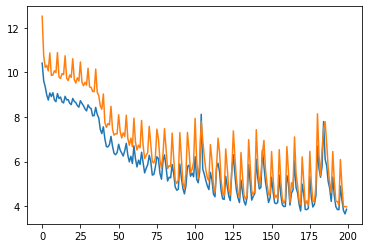

In [15]:
pplot.plot(loss_log.loss_history['loss'])
pplot.plot(loss_log.loss_history['val_loss'])


5


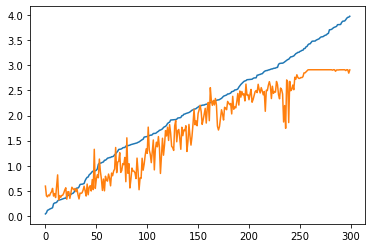

In [16]:
#loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
#loss_vals
print(nnodes)

ids_sort = np.argsort(y_curr);
pplot.plot(y_curr[ids_sort])
pplot.plot(prob_out.mean().numpy().flatten()[ids_sort])

In [17]:
ee = 1
nnodes = 1
graphs, y_times = get_graph_data(ee, X_ = X, eid_oh_ = eid_oh, yrem_norm_ = yrem_norm, n_sampled_graphs = nsampled, nnodes=nnodes)
rnn_dat = graph_dat_to_rnn_dat(graphs,1)

NameError: name 'nsampled' is not defined

In [18]:
res = rnn_gamma_model((rnn_dat[1], rnn_dat[0]))



NameError: name 'rnn_dat' is not defined

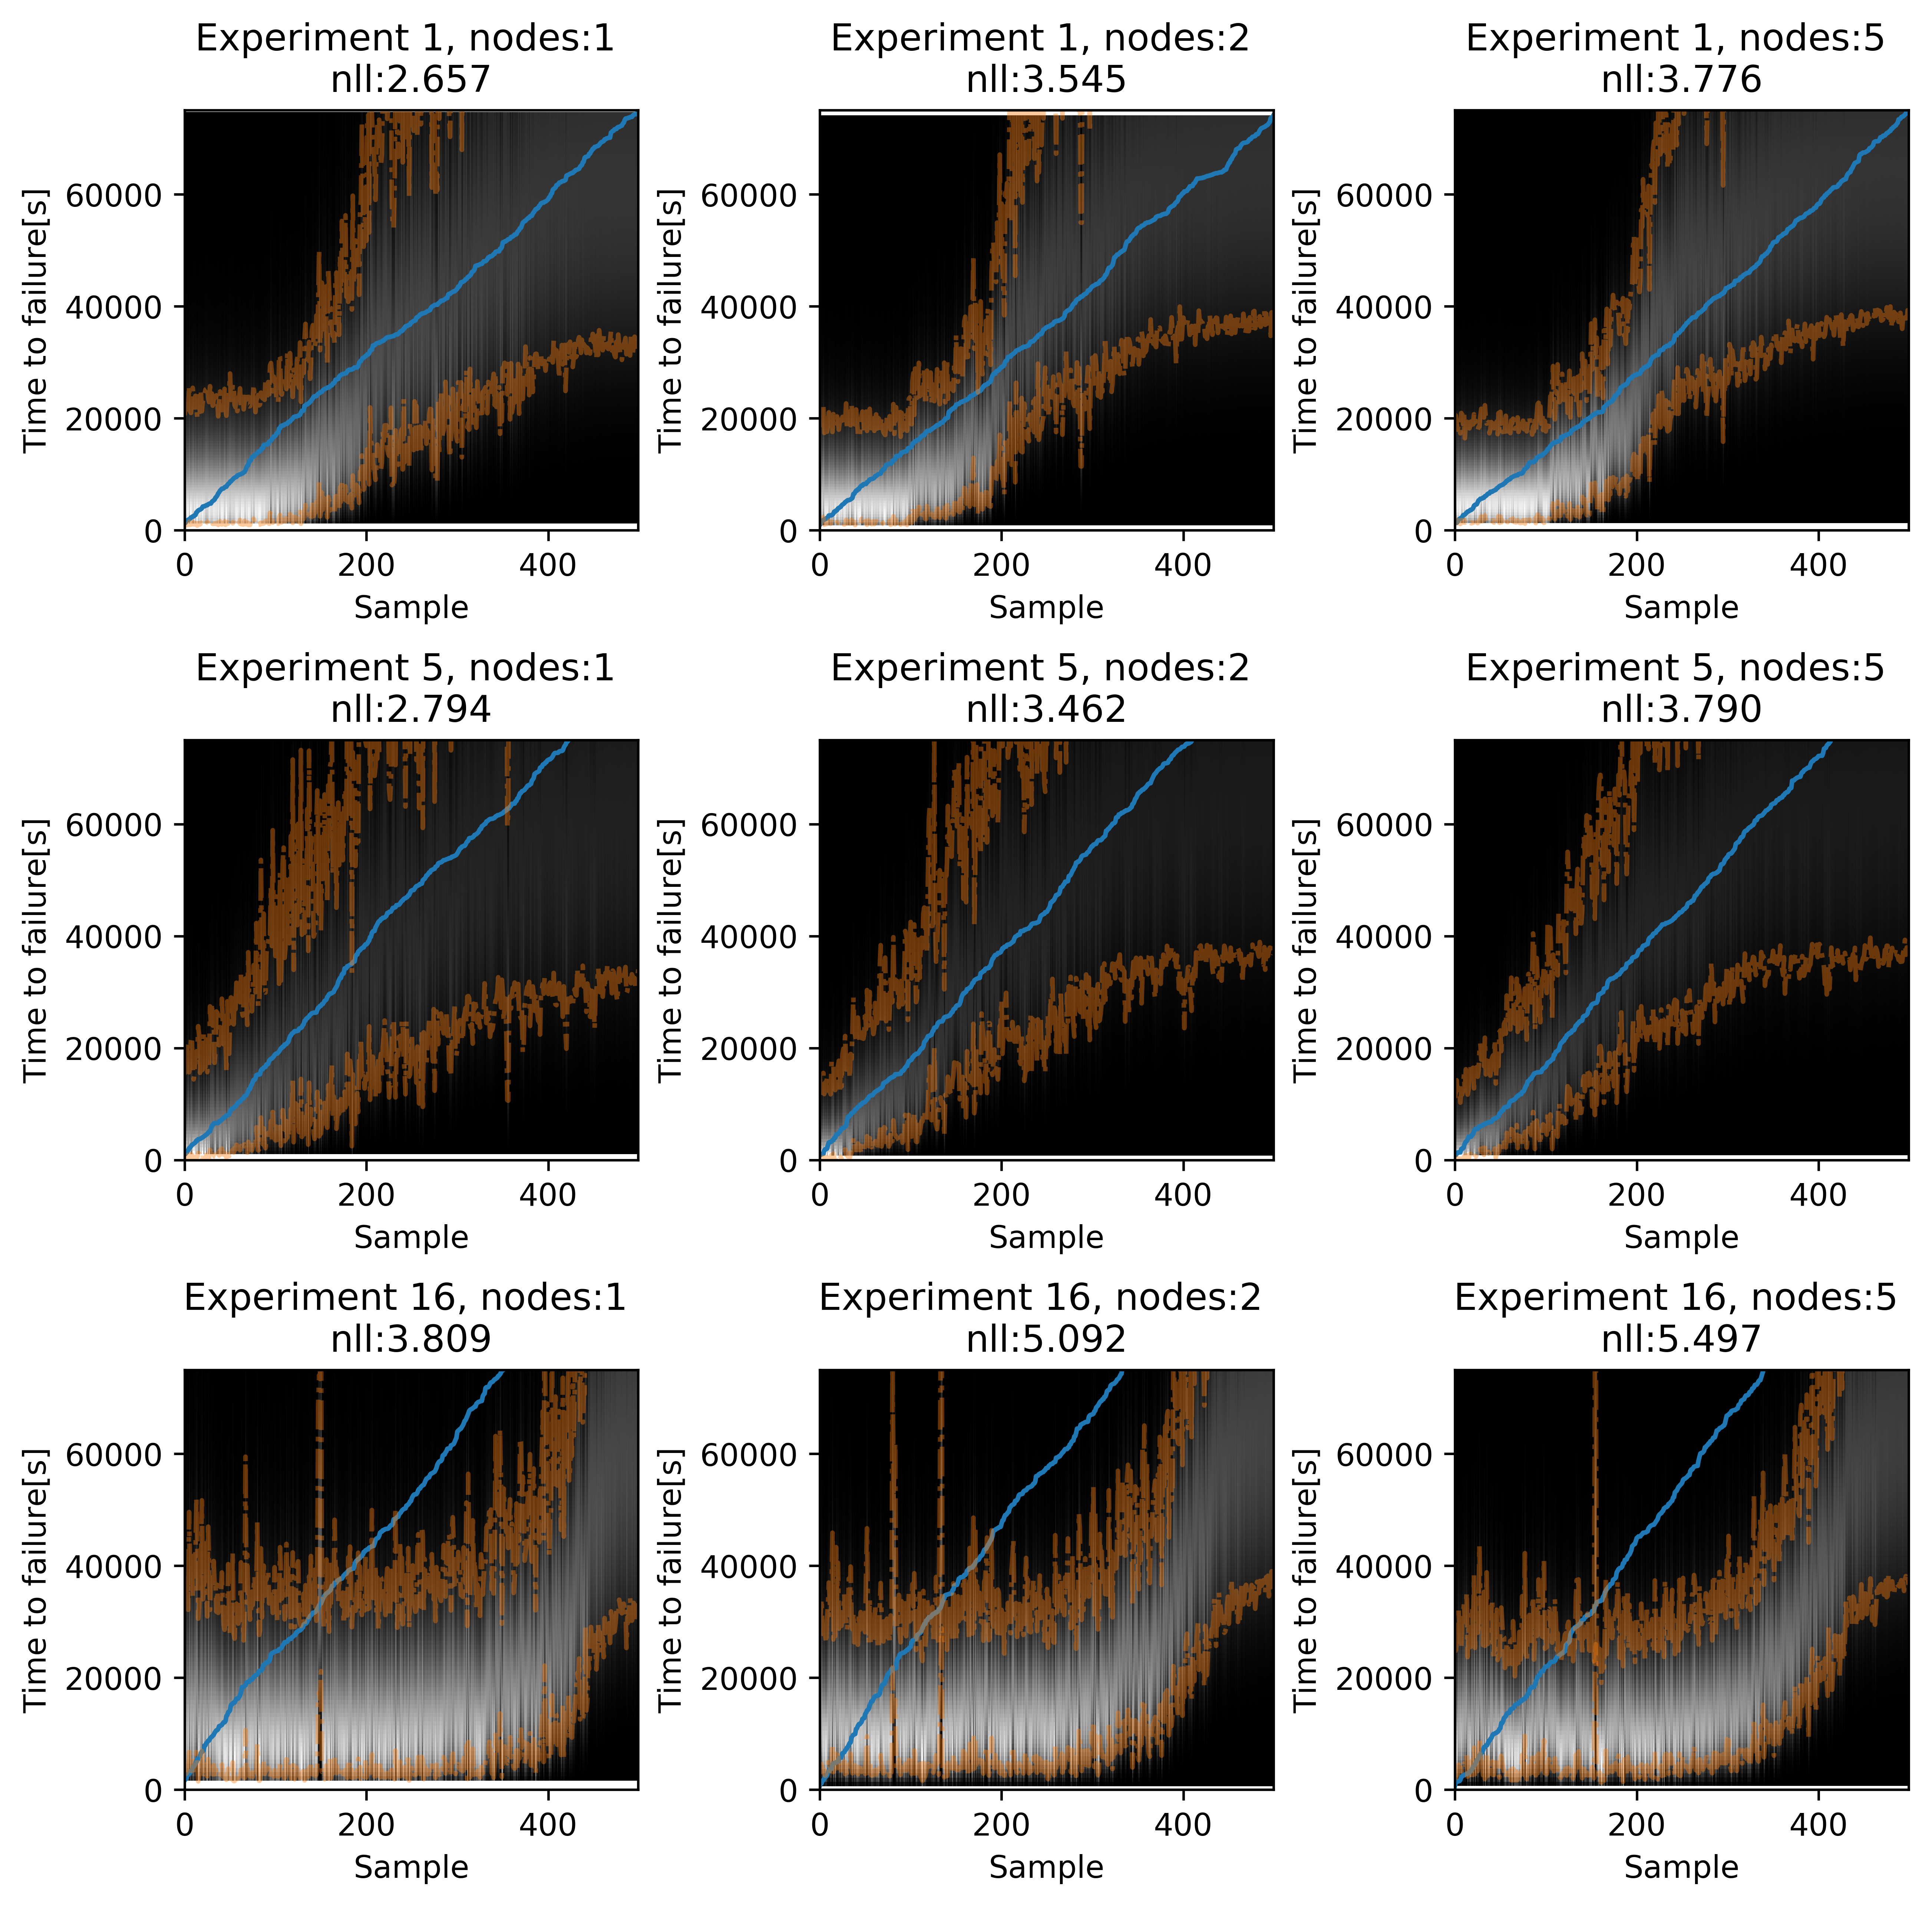

In [19]:
unseen = inds_exp_target[0:3]
training = inds_exp_source
nsampled = 500
nnodes = 1
ee = unseen[1]
ee = training[0]

pplot.figure(figsize = (10,10), dpi = 600)
nnodes_list = [1,2,5]#,4]
kk = 0;
for ee in unseen:
    for nnodes in nnodes_list:
        #ee = training[0]
        graphs, y_times = get_graph_data(ee, X_ = X, eid_oh_ = eid_oh,
                                         yrem_norm_ = yrem_norm, n_sampled_graphs = nsampled, 
                                         nnodes=nnodes)
        
        d = graph_dat_to_rnn_dat(graphs,1)
        dat_ = [d[1] ,d[0]]
        probs = rnn_gamma_model(dat_)
        ids_sorted = np.argsort(y_times)
        time_grid = np.linspace(np.min(y_times),np.max(y_times), 150);
        e_y = probs.mean()
        p_y = probs.prob(time_grid).numpy().T
        y_times_sorted = y_times[ids_sorted];
        pplot.subplot(len(unseen), len(nnodes_list), kk+1)
        pplot.pcolor([r for r in range(p_y.shape[1])], time_grid * normalization_factor_time, p_y[:,ids_sorted]**0.9, cmap = "gray")
        pplot.plot(y_times_sorted*normalization_factor_time)
        
        q90 = np.quantile(probs.sample(1000).numpy(),[0.05,0.95],0)[:,:,0].T[ids_sorted]
        pplot.plot(q90*normalization_factor_time,'C1-.', alpha = 0.4)
        pplot.ylim(0,75000)
        nll = -np.mean(probs.log_prob(y_times))
        
        title = "Experiment %i, nodes:%i \nnll:%2.3f"%(ee,nnodes,nll)
        pplot.xlabel("Sample")
        pplot.ylabel("Time to failure[s]")
        pplot.title(title)
        kk+=1
        #p_y.shape
        #pplot.show()
pplot.subplots_adjust(hspace = 0.5, wspace = 0.4)
pplot.show()


In [22]:
d = graph_dat_to_rnn_dat(graphs,1)

In [71]:
ids_sorted_ = np.argsort(y_times)
ids_sorted_ = np.flip(ids_sorted_)

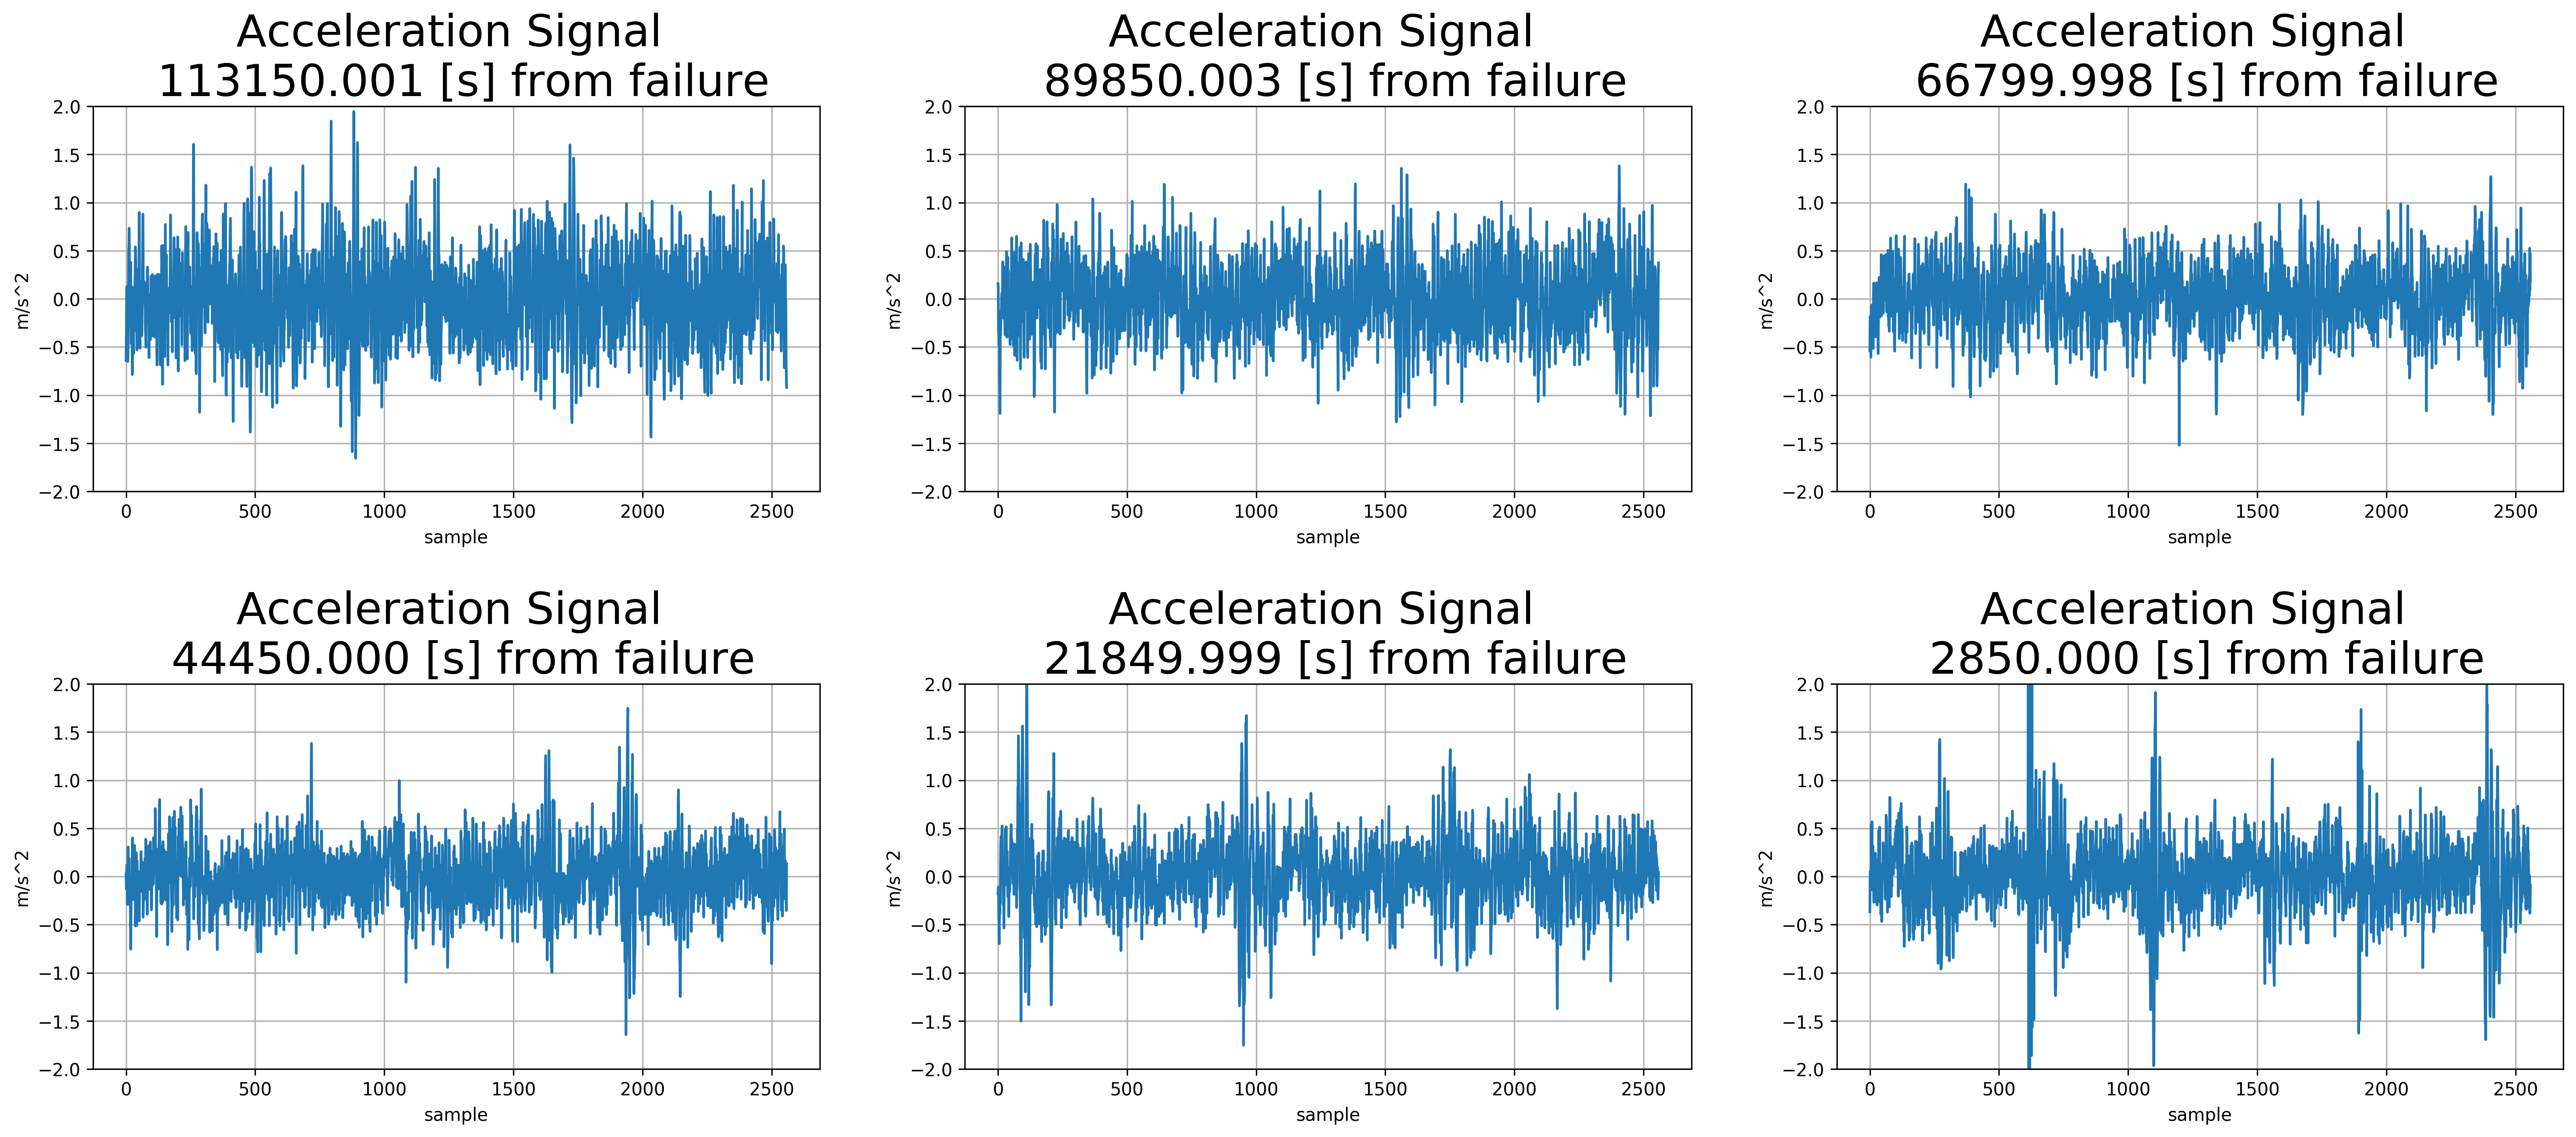

In [80]:
idx =2

pplot.figure(figsize = (25,10), dpi = 300)
for i,idx in enumerate([2,100,200,300,400,485]):
    ii = ids_sorted_[idx]
    pplot.subplot(2,3,i+1)
    pplot.plot(d[0][ii,-5][:,0])
    pplot.ylabel("m/s^2")
    pplot.xlabel('sample')
    pplot.title("Acceleration Signal \n %2.3f [s] from failure"%(y_times[ii]*normalization_factor_time), fontsize = 25)
    pplot.ylim(-2.0,2.0)
    pplot.grid()
#pplot.show()
#pplot.plot(d[0][123,-5][:,0])
pplot.subplots_adjust(hspace=0.5)

In [54]:
normalization_factor_time

25000

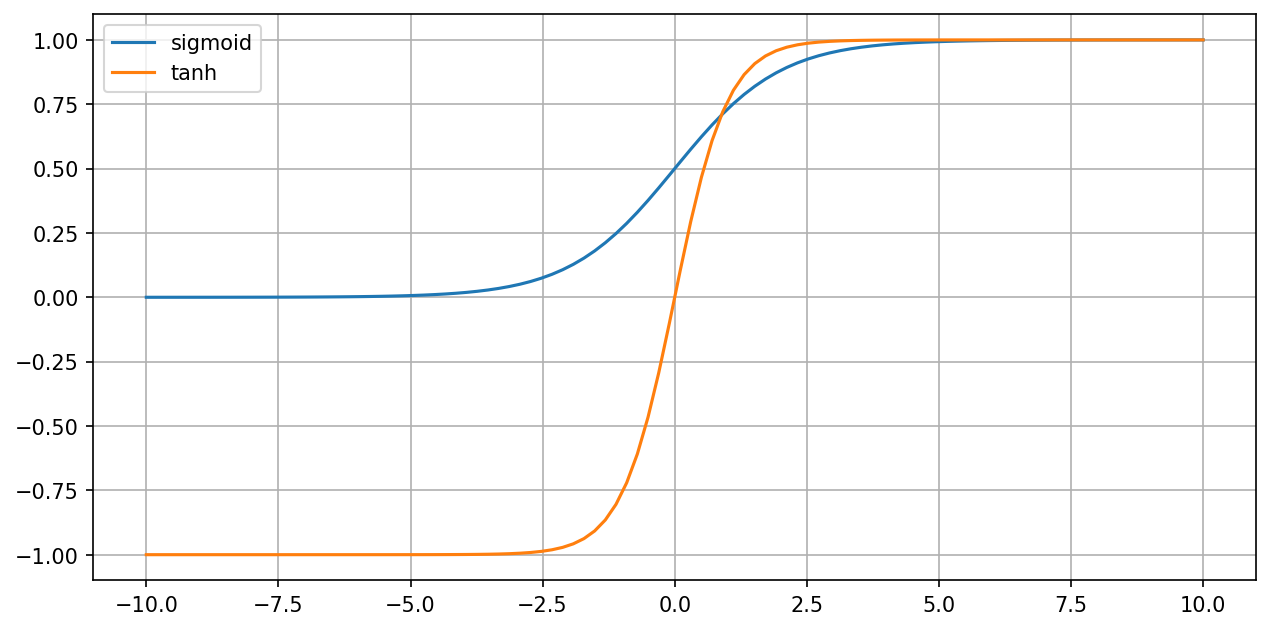

In [95]:
pplot.figure ( figsize = (10,5), dpi = 150)
sigmoid = lambda x : 1-1/(1+np.exp(x))
tanh = lambda x : np.tanh(x)
x = np.linspace(-10,10,100)
pplot.plot(x,sigmoid(x), label = "sigmoid")
pplot.plot(x,tanh(x), label = "tanh")
pplot.grid()
pplot.legend()


## Gated RNN update:

\begin{align*} 
  c_{t} = & Sigmoid(g_h(x_t, h_{t-1})) \odot tanh(f_h(x_t, h_{t-1})) \\  &+ Sigmoid(g_f(x_t, h_{t-1})) \odot c_{t-1} 
 \end{align*}

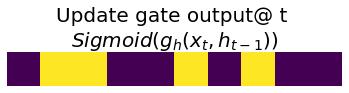

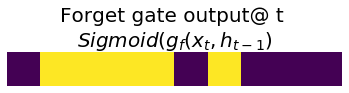

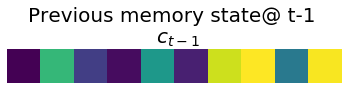

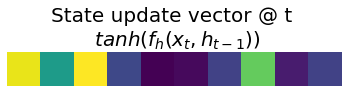

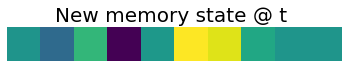

In [140]:
g_h_input = np.random.randn(10,1)*100
g_f_input = np.random.randn(10,1)*100

r1 = np.random.randn(10,1)
r2 = np.random.randn(10,1)
r3 = np.random.randn(10,1)


g_h = sigmoid(g_h_input).T
pplot.axis("off")
pplot.imshow(g_h)
pplot.title("Update gate output@ t \n$Sigmoid(g_h(x_t, h_{t-1}))$", fontsize = 20)
pplot.show()

g_f = sigmoid(g_f_input).T
pplot.axis("off")
pplot.imshow(g_f>0.5)
pplot.title("Forget gate output@ t \n$Sigmoid(g_f(x_t, h_{t-1})$",fontsize = 20)
pplot.show()

c_tm1 = tanh(r1).T
pplot.axis("off")
pplot.imshow(c_tm1)
pplot.title("Previous memory state@ t-1 \n $ c_{t-1} $",fontsize = 20)
pplot.show()

gate_t_val = tanh(x_in_t)


h_tm1 = tanh(r2).T
pplot.axis("off")
pplot.imshow(h_tm1)
pplot.title("State update vector @ t \n $ tanh(f_h(x_t, h_{t-1})) $",fontsize = 20)
pplot.show()


h_tm1 = tanh(r3).T
pplot.axis("off")
pplot.imshow(h_tm1 * g_h + c_tm1 * g_f)
pplot.title("New memory state @ t ",fontsize = 20)
pplot.show()



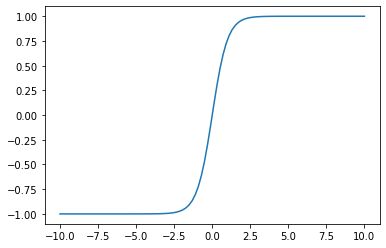